In [3]:
%matplotlib inline
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [319]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
    def forward(self, input, hidden):
        
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
            
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [320]:
def makeData(npoints = 500, f = None):
    
    if f is None:
        f = lambda x: x*x + 10
    
    x = np.arange(npoints)
    
    y = np.array(list(map(f, x)))
    
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    
    return x, y

In [321]:
def sequence_train_test_split(sequence, test = 0.2):
    
    n = len(x)
    
    indices = np.arange(n)
    
    train_split = 1 - test
    ntrain = int(len(x) * train_split)
    
    train_indices, test_indices = indices[:ntrain], indices[ntrain:]
    
    train_sequence = sequence[train_indices]
    test_sequence = sequence[test_indices]
    
    train_input = train_sequence[:-1].unsqueeze(2)
    train_target = train_sequence[1:]
    
    test_input = test_sequence[:-1].unsqueeze(2)
    test_target = test_sequence[1:]
    
    t_train = np.arange(train_input.size(0))
    t_test = np.arange(train_input.size(0), train_input.size(0) + test_input.size(0))
    
    return train_input, test_input, train_target, test_target, t_train, t_test

In [339]:
def train(rnn, train_input, train_target, lr = 0.001, epochs = 1000, plot = True):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(rnn.parameters(), lr = lr)
    
    try:
        for epoch in range(epochs):

            hidden = rnn.initHidden()

            loss = 0
            outputs = []
            for i, input in enumerate(train_input):
                output, hidden = rnn(input, hidden)
                outputs += [output]
                l = criterion(output, train_target[i])
                loss += l
            
            #loss = Variable(loss, requires_grad = True)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 500 == 0:
                print('epoch {}, loss {}'.format(epoch, loss))
            
            pred_target = torch.Tensor(outputs).view(-1,1)
            
    except KeyboardInterrupt:
        pass
    
    if plot:
        
        with torch.no_grad():
            t = np.arange(train_input.size(0))

            plt.scatter(t, pred_target.detach().numpy(), color = 'red', s = 15)
            plt.scatter(t, train_target.detach().numpy(), color = 'blue', s = 10)
            
    return rnn

In [340]:
n_input = 1
n_hidden = 128
n_output = 1
rnn = RNN(n_input, n_hidden, n_output)

In [341]:
npoints = 50
f = lambda x: np.sin(x)
x, y = makeData(npoints=npoints, f = f)

In [342]:
train_input, test_input, train_target, test_target, t_train, t_test = sequence_train_test_split(y)

In [343]:
train_input.size()

torch.Size([39, 1, 1])

In [344]:
train_target.size()

torch.Size([39, 1])

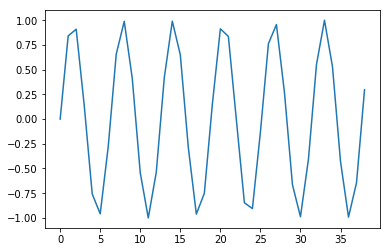

In [345]:
plt.plot(t_train, train_input[:,:,0].numpy())

epoch 0, loss 22.502405166625977
epoch 500, loss 1.0568516254425049


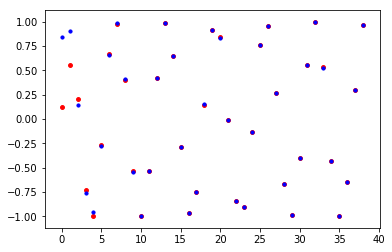

In [346]:
rnn = train(rnn, train_input, train_target, lr = 0.0001, epochs=1000)